In [5]:
#Grouping two datasets by videoid first / also known as DOCUMENT POOLING-> objective:to fix small text issue for LDA to make sure it can work

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Fix numpy compatibility issue
import numpy
if not hasattr(numpy, '_no_nep50_warning'):
    numpy._no_nep50_warning = lambda: None

# Load the latest processed comments (from your spam detection pipeline)
comments_df = pd.read_csv('complete_comments_top20_features.csv')
print(f"Loaded comments: {len(comments_df):,} rows")

# Load original videos dataset
videos_df = pd.read_csv('../dataset/videos.csv')
print(f"Loaded videos: {len(videos_df):,} rows")

# Check unique videoIds in each dataset
unique_videos_in_comments = comments_df['videoId'].nunique()
unique_videos_in_videos = videos_df['videoId'].nunique()

print(f"\nUnique videoIds in comments: {unique_videos_in_comments:,}")
print(f"Unique videoIds in videos: {unique_videos_in_videos:,}")

# Find videos without comments and comments without videos
videos_with_comments = set(comments_df['videoId'].unique())
videos_in_dataset = set(videos_df['videoId'].unique())

videos_without_comments = videos_in_dataset - videos_with_comments
comments_without_videos = videos_with_comments - videos_in_dataset

print(f"\nMERGE STATISTICS:")
print(f"Videos without any comments: {len(videos_without_comments):,}")
print(f"Comments referencing non-existent videos: {len(comments_without_videos):,}")

# Show some examples if they exist
if videos_without_comments:
    print(f"\nExample videos without comments: {list(videos_without_comments)[:5]}")
if comments_without_videos:
    print(f"Example videoIds in comments but not in videos: {list(comments_without_videos)[:5]}")

# Perform the merge - keeping all comments that have matching videos
merged_df = comments_df.merge(videos_df, on='videoId', how='inner', suffixes=('_comment', '_video'))

print(f"\nMERGE RESULTS:")
print(f"Comments before merge: {len(comments_df):,}")
print(f"Comments after merge: {len(merged_df):,}")
print(f"Comments lost in merge: {len(comments_df) - len(merged_df):,}")
print(f"Videos included in merge: {merged_df['videoId'].nunique():,}")

# Show what happens to comment IDs - they are preserved!
print(f"\nComment IDs preserved: All {len(merged_df):,} comment IDs remain intact")
print(f"Each row still represents one comment, now enriched with video metadata")

print(f"\nMERGED DATASET COLUMNS:")
print("Comment columns:", [col for col in merged_df.columns if col.endswith('_comment') or col in ['commentId', 'textOriginal', 'likeCount_comment']])
print("Video columns:", [col for col in merged_df.columns if col.endswith('_video') or col in ['title', 'description', 'tags']])
print("Shared columns:", [col for col in merged_df.columns if not col.endswith('_comment') and not col.endswith('_video') and col != 'videoId'])

# Display merged dataframe in table format
print("\nSAMPLE OF MERGED DATA:")
print("="*100)

# Select key columns for easier viewing
key_columns = ['commentId', 'videoId', 'textOriginal', 'title', 'description', 'likeCount_comment', 'viewCount']
display_df = merged_df[key_columns].head()

# Set pandas display options for better table formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print(display_df.to_string(index=False))
print("="*100)

Loaded comments: 3,326,124 rows
Loaded videos: 92,759 rows

Unique videoIds in comments: 36,375
Unique videoIds in videos: 92,759

MERGE STATISTICS:
Videos without any comments: 56,472
Comments referencing non-existent videos: 88

Example videos without comments: [1, 3, 4, 5, 7]
Example videoIds in comments but not in videos: [0, 89600, 59912, 53272, 61977]
Loaded videos: 92,759 rows

Unique videoIds in comments: 36,375
Unique videoIds in videos: 92,759

MERGE STATISTICS:
Videos without any comments: 56,472
Comments referencing non-existent videos: 88

Example videos without comments: [1, 3, 4, 5, 7]
Example videoIds in comments but not in videos: [0, 89600, 59912, 53272, 61977]

MERGE RESULTS:
Comments before merge: 3,326,124
Comments after merge: 3,325,035
Comments lost in merge: 1,089
Videos included in merge: 36,287

Comment IDs preserved: All 3,325,035 comment IDs remain intact
Each row still represents one comment, now enriched with video metadata

MERGED DATASET COLUMNS:
Comment

In [6]:
# Document Pooling - Create mega-documents per video for LDA topic modeling

# Safety check - ensure required variables exist
if 'merged_df' not in locals():
    print("❌ Error: merged_df not found. Please run cell 1 first!")
    raise NameError("merged_df not defined. Run the previous cell first.")

print(f"✅ Starting document pooling with {len(merged_df):,} comments")

# Check available columns first
print("Available columns in merged_df:")
print(merged_df.columns.tolist())
print()

# Filter for quality comments only (remove spam for clean topic modeling)
spam_col = None
if 'spam_classification' in merged_df.columns:
    spam_col = 'spam_classification'
elif 'final_labels' in merged_df.columns:
    spam_col = 'final_labels'

if spam_col:
    # Check what values are in the spam classification column
    print(f"Found spam classification column: '{spam_col}'")
    unique_values = merged_df[spam_col].value_counts()
    print(f"Unique values in {spam_col}: {dict(unique_values)}")
    
    # Filter for quality comments only
    quality_comments = merged_df[merged_df[spam_col] == 'quality'].copy()
    print(f"Using {len(quality_comments):,} quality comments from {quality_comments['videoId'].nunique():,} videos")
else:
    # No spam classification available - use all comments
    print("⚠️  No spam classification found. Using ALL comments for topic modeling.")
    print("   Run the spam detection pipeline first for better results.")
    quality_comments = merged_df.copy()
    print(f"Using {len(quality_comments):,} total comments from {quality_comments['videoId'].nunique():,} videos")

# Group by videoId and create pooled documents
pooled_documents = []
video_metadata = []

for video_id, group in quality_comments.groupby('videoId'):
    # Get video metadata (first row since all rows have same video info)
    video_info = group.iloc[0]
    
    # Collect all comment texts for this video
    comment_texts = group['textOriginal'].fillna('').tolist()
    
    # Create the pooled document: video title + description + all comments
    video_title = str(video_info.get('title', '')).strip()
    video_description = str(video_info.get('description', '')).strip()
    
    # Combine all text for this video
    pooled_text_parts = []
    
    if video_title:
        pooled_text_parts.append(f"TITLE: {video_title}")
    
    if video_description:
        pooled_text_parts.append(f"DESCRIPTION: {video_description}")
    
    # Add all quality comments
    if comment_texts:
        comment_text = " ".join([str(text).strip() for text in comment_texts if str(text).strip()])
        if comment_text:
            pooled_text_parts.append(f"COMMENTS: {comment_text}")
    
    # Create final pooled document
    pooled_document = " ".join(pooled_text_parts)
    
    if pooled_document.strip():  # Only add if document has content
        pooled_documents.append(pooled_document)
        
        # Store metadata for this video-document
        video_metadata.append({
            'videoId': video_id,
            'title': video_title,
            'description': video_description,
            'num_comments': len(comment_texts),
            'viewCount': video_info.get('viewCount', 0),
            'likeCount_video': video_info.get('likeCount_video', 0),
            'document_length': len(pooled_document),
            'publishedAt_video': video_info.get('publishedAt_video', '')
        })

print(f"\nDocument Pooling Results:")
print(f"Created {len(pooled_documents)} pooled documents")
print(f"Average document length: {np.mean([len(doc) for doc in pooled_documents]):.0f} characters")
print(f"Total characters: {sum(len(doc) for doc in pooled_documents):,}")

# Convert to DataFrame for easier handling
pooled_df = pd.DataFrame(video_metadata)
pooled_df['pooled_text'] = pooled_documents

print(f"\nSample pooled document:")
print("="*80)
sample_doc = pooled_documents[0][:500] + "..." if len(pooled_documents[0]) > 500 else pooled_documents[0]
print(sample_doc)
print("="*80)

✅ Starting document pooling with 3,325,035 comments
Available columns in merged_df:
['kind_comment', 'commentId', 'channelId_comment', 'videoId', 'authorId', 'textOriginal', 'parentCommentId', 'likeCount_comment', 'publishedAt_comment', 'updatedAt', 'char_count', 'word_count', 'caps_ratio', 'repetition_ratio', 'emoji_ratio', 'emoji_diversity', 'likes_per_char', 'is_reply', 'url_count', 'is_generic', 'spam_classification', 'classification_confidence', 'kind_video', 'publishedAt_video', 'channelId_video', 'title', 'description', 'tags', 'defaultLanguage', 'defaultAudioLanguage', 'contentDuration', 'viewCount', 'likeCount_video', 'favouriteCount', 'commentCount', 'topicCategories']

Found spam classification column: 'spam_classification'
Unique values in spam_classification: {'quality': 3087679, 'spam': 235289, 'uncertain': 2067}
Using 3,087,679 quality comments from 34,949 videos
Using 3,087,679 quality comments from 34,949 videos

Document Pooling Results:
Created 34949 pooled documents

In [ ]:
# Topic Modeling - Import libraries
pip install "scipy<1.13" "gensim==4.3.0"
import gensim
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import time

print("Topic modeling libraries loaded successfully!")

Note: you may need to restart the kernel to use updated packages.
Topic modeling libraries loaded successfully!



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
# Direct LDA Processing - Skip preprocessing, use gensim's built-in tools
print("Creating LDA corpus directly from pooled documents...")

# Use gensim's simple_preprocess for basic tokenization
from gensim.utils import simple_preprocess

# Convert pooled documents to simple token lists (removes punctuation, lowercases, filters length)
processed_docs = [simple_preprocess(doc, deacc=True, min_len=2, max_len=15) for doc in pooled_documents]

# Remove empty documents
processed_docs = [doc for doc in processed_docs if len(doc) > 0]

print(f"Processed {len(processed_docs)} documents")
print(f"Average tokens per document: {np.mean([len(doc) for doc in processed_docs]):.1f}")

# Create dictionary and corpus for Gensim
dictionary = corpora.Dictionary(processed_docs)

# Filter extreme cases
dictionary.filter_extremes(
    no_below=2,      # Remove words that appear in less than 2 documents
    no_above=0.8,    # Remove words that appear in more than 80% of documents
    keep_n=10000     # Keep only top 10000 most frequent words
)

print(f"Dictionary size after filtering: {len(dictionary)} unique tokens")

# Create corpus (bag of words representation)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

print(f"Corpus created: {len(corpus)} documents")
print(f"Sample document representation: {corpus[0][:10]}...")  # Show first 10 terms

Creating LDA corpus directly from pooled documents...
Processed 34949 documents
Average tokens per document: 698.3
Processed 34949 documents
Average tokens per document: 698.3
Dictionary size after filtering: 10000 unique tokens
Dictionary size after filtering: 10000 unique tokens
Corpus created: 34949 documents
Sample document representation: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]...
Corpus created: 34949 documents
Sample document representation: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]...


Finding optimal number of topics...
Training LDA model with 4 topics...
Coherence score for 4 topics: 0.4139
Training LDA model with 6 topics...
Coherence score for 4 topics: 0.4139
Training LDA model with 6 topics...
Coherence score for 6 topics: 0.4733
Training LDA model with 8 topics...
Coherence score for 6 topics: 0.4733
Training LDA model with 8 topics...
Coherence score for 8 topics: 0.4782
Training LDA model with 10 topics...
Coherence score for 8 topics: 0.4782
Training LDA model with 10 topics...
Coherence score for 10 topics: 0.4791
Training LDA model with 12 topics...
Coherence score for 10 topics: 0.4791
Training LDA model with 12 topics...
Coherence score for 12 topics: 0.5030
Training LDA model with 14 topics...
Coherence score for 12 topics: 0.5030
Training LDA model with 14 topics...
Coherence score for 14 topics: 0.5050
Training LDA model with 16 topics...
Coherence score for 14 topics: 0.5050
Training LDA model with 16 topics...
Coherence score for 16 topics: 0.4987


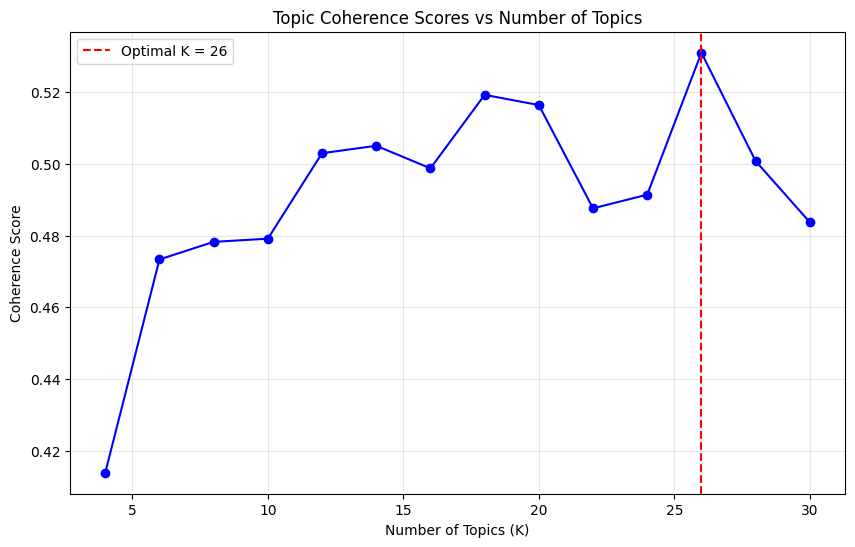


Selected LDA model with 26 topics


In [9]:
# Step 3: LDA Model Training with K Optimization
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """Compute coherence values for different numbers of topics."""
    
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        print(f"Training LDA model with {num_topics} topics...")
        
        # Train LDA model
        model = models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True
        )
        
        model_list.append(model)
        
        # Calculate coherence
        coherencemodel = CoherenceModel(
            model=model, 
            texts=texts, 
            dictionary=dictionary, 
            coherence='c_v'
        )
        
        coherence_values.append(coherencemodel.get_coherence())
        print(f"Coherence score for {num_topics} topics: {coherence_values[-1]:.4f}")
    
    return model_list, coherence_values

# Test different numbers of topics
print("Finding optimal number of topics...")
start_time = time.time()

# Test K values from 4 to 30 with step 2
model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus, 
    texts=processed_docs,
    start=4,
    limit=31,
    step=2  #inc 2
)

optimization_time = time.time() - start_time
print(f"\nModel optimization completed in {optimization_time:.2f} seconds")

# Find optimal number of topics
topic_range = list(range(4, 31, 2))
optimal_idx = np.argmax(coherence_values)
optimal_k = topic_range[optimal_idx]
optimal_coherence = coherence_values[optimal_idx]

print(f"\nOptimal number of topics: {optimal_k}")
print(f"Best coherence score: {optimal_coherence:.4f}")

# Plot coherence scores
plt.figure(figsize=(10, 6))
plt.plot(topic_range, coherence_values, 'bo-')
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal K = {optimal_k}')
plt.xlabel('Number of Topics (K)')
plt.ylabel('Coherence Score')
plt.title('Topic Coherence Scores vs Number of Topics')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Select the best model
best_lda_model = model_list[optimal_idx]
print(f"\nSelected LDA model with {optimal_k} topics")

In [10]:
# Step 4: Topic Assignment - Label each video with dominant topic
def get_dominant_topic(ldamodel, corpus, video_metadata):
    """Get dominant topic for each video document."""
    
    video_topics = []
    
    for i, doc in enumerate(corpus):
        # Get topic distribution for this document
        topic_distribution = ldamodel.get_document_topics(doc)
        
        if topic_distribution:
            # Find dominant topic (highest probability)
            dominant_topic = max(topic_distribution, key=lambda x: x[1])
            topic_id, topic_prob = dominant_topic
            
            # Get video metadata
            video_info = video_metadata[i]
            
            video_topics.append({
                'videoId': video_info['videoId'],
                'video_title': video_info['title'],
                'num_comments': video_info['num_comments'],
                'viewCount': video_info['viewCount'],
                'dominant_topic': topic_id,
                'topic_probability': topic_prob,
                'document_length': video_info['document_length']
            })
        else:
            # Handle case where no topics found
            video_info = video_metadata[i]
            video_topics.append({
                'videoId': video_info['videoId'],
                'video_title': video_info['title'],
                'num_comments': video_info['num_comments'],
                'viewCount': video_info['viewCount'],
                'dominant_topic': -1,  # No topic assigned
                'topic_probability': 0.0,
                'document_length': video_info['document_length']
            })
    
    return video_topics

# Assign topics to videos
print("Assigning dominant topics to videos...")
video_topics = get_dominant_topic(best_lda_model, corpus, video_metadata)

# Convert to DataFrame
video_topics_df = pd.DataFrame(video_topics)

print(f"Assigned topics to {len(video_topics_df)} videos")
print(f"Videos without topic assignment: {(video_topics_df['dominant_topic'] == -1).sum()}")

# Show topic distribution across videos
topic_distribution = video_topics_df['dominant_topic'].value_counts().sort_index()
print(f"\nTopic distribution across videos:")
for topic_id, count in topic_distribution.items():
    if topic_id != -1:
        percentage = count / len(video_topics_df) * 100
        print(f"  Topic {topic_id}: {count} videos ({percentage:.1f}%)")

# Show sample video assignments
print(f"\nSample video topic assignments:")
print("="*100)
sample_assignments = video_topics_df.head(10)[['videoId', 'video_title', 'dominant_topic', 'topic_probability', 'num_comments']]
for _, row in sample_assignments.iterrows():
    title = row['video_title'][:50] + "..." if len(str(row['video_title'])) > 50 else row['video_title']
    print(f"Video: {title}")
    print(f"  Topic: {row['dominant_topic']} (confidence: {row['topic_probability']:.3f}, {row['num_comments']} comments)")
    print()
print("="*100)

Assigning dominant topics to videos...
Assigned topics to 34949 videos
Videos without topic assignment: 0

Topic distribution across videos:
  Topic 0: 109 videos (0.3%)
  Topic 1: 832 videos (2.4%)
  Topic 2: 363 videos (1.0%)
  Topic 3: 2408 videos (6.9%)
  Topic 4: 247 videos (0.7%)
  Topic 5: 1940 videos (5.6%)
  Topic 6: 4008 videos (11.5%)
  Topic 7: 299 videos (0.9%)
  Topic 8: 166 videos (0.5%)
  Topic 9: 318 videos (0.9%)
  Topic 10: 1053 videos (3.0%)
  Topic 11: 181 videos (0.5%)
  Topic 12: 409 videos (1.2%)
  Topic 13: 44 videos (0.1%)
  Topic 14: 4698 videos (13.4%)
  Topic 15: 1666 videos (4.8%)
  Topic 16: 74 videos (0.2%)
  Topic 17: 369 videos (1.1%)
  Topic 18: 1195 videos (3.4%)
  Topic 19: 350 videos (1.0%)
  Topic 20: 8076 videos (23.1%)
  Topic 21: 5944 videos (17.0%)
  Topic 22: 75 videos (0.2%)
  Topic 23: 1 videos (0.0%)
  Topic 24: 85 videos (0.2%)
  Topic 25: 39 videos (0.1%)

Sample video topic assignments:
Video: Let’s give happiness #toupee #barber #hairl

In [11]:
# Step 5: Extract Topic Keywords with Frequencies
def extract_topic_keywords(ldamodel, dictionary, num_words=20):
    """Extract keywords and their probabilities for each topic."""
    
    topic_keywords = []
    
    for topic_id in range(ldamodel.num_topics):
        # Get top words for this topic
        topic_words = ldamodel.show_topic(topic_id, topn=num_words)
        
        for word, probability in topic_words:
            # Get word frequency in corpus
            word_id = dictionary.token2id.get(word, -1)
            word_frequency = dictionary.dfs.get(word_id, 0) if word_id != -1 else 0
            
            topic_keywords.append({
                'topic_id': topic_id,
                'keyword': word,
                'probability': probability,
                'frequency': word_frequency,
                'rank': len([x for x in topic_words[:topic_words.index((word, probability)) + 1]])
            })
    
    return topic_keywords

# Extract keywords for all topics
print("Extracting topic keywords...")
topic_keywords = extract_topic_keywords(best_lda_model, dictionary, num_words=15)

# Convert to DataFrame
topic_keywords_df = pd.DataFrame(topic_keywords)

print(f"Extracted {len(topic_keywords_df)} keywords across {optimal_k} topics")

# Display topics with their top keywords
print(f"\n=== DISCOVERED TOPICS ===")
for topic_id in range(optimal_k):
    topic_data = topic_keywords_df[topic_keywords_df['topic_id'] == topic_id]
    top_keywords = topic_data.head(10)
    
    # Count videos in this topic
    videos_in_topic = (video_topics_df['dominant_topic'] == topic_id).sum()
    
    print(f"\nTopic {topic_id} ({videos_in_topic} videos):")
    keywords_list = []
    for _, row in top_keywords.iterrows():
        keywords_list.append(f"{row['keyword']}({row['probability']:.3f})")
    
    print(f"  Keywords: {', '.join(keywords_list)}")
    
    # Show example videos for this topic
    example_videos = video_topics_df[video_topics_df['dominant_topic'] == topic_id].head(3)
    if not example_videos.empty:
        print(f"  Example videos:")
        for _, video in example_videos.iterrows():
            title = video['video_title'][:60] + "..." if len(str(video['video_title'])) > 60 else video['video_title']
            print(f"    - {title} (confidence: {video['topic_probability']:.3f})")

print("="*80)

Extracting topic keywords...
Extracted 390 keywords across 26 topics

=== DISCOVERED TOPICS ===

Topic 0 (109 videos):
  Keywords: no(0.206), de(0.085), que(0.056), se(0.034), para(0.026), da(0.023), mas(0.021), si(0.019), na(0.017), com(0.016)
  Example videos:
    - 💗 DOVE REGENERAÇÃO EXTREMA! SHAMPOO E CONDICIONADOR - VALE A... (confidence: 0.599)
    - Body Splash Virgínia #shortsfeed #shortsvideo #shortsyoutube... (confidence: 0.229)
    - a importância da rare beauty para o mundo da beleza 💗 (confidence: 0.419)

Topic 1 (832 videos):
  Keywords: you(0.174), beautiful(0.083), so(0.082), are(0.062), your(0.055), look(0.039), pretty(0.035), love(0.028), gorgeous(0.020), and(0.019)
  Example videos:
    - glitter skin ✨ ft. one size glitter setting spray #shorts (confidence: 0.366)
    - Face and body highlighter #productreview #makeupinfluencer #... (confidence: 0.252)
    - Nainowaale ne #browngirl #ytshorts (confidence: 0.221)

Topic 2 (363 videos):
  Keywords: you(0.160), thank(0

Exporting topic modeling results...
✅ Exported video topic assignments: video_topics_assignment.csv
✅ Exported topic keywords: topic_keywords_frequencies.csv

=== TOPIC MODELING SUMMARY ===
Total Videos Analyzed: 34,949
Number of Topics Discovered: 26
Average Topic Confidence: 0.353
Pooled Documents Created: 34,949
Average Comments per Video: 88.3
Model Coherence Score: 0.5310
✅ Exported video topic assignments: video_topics_assignment.csv
✅ Exported topic keywords: topic_keywords_frequencies.csv

=== TOPIC MODELING SUMMARY ===
Total Videos Analyzed: 34,949
Number of Topics Discovered: 26
Average Topic Confidence: 0.353
Pooled Documents Created: 34,949
Average Comments per Video: 88.3
Model Coherence Score: 0.5310


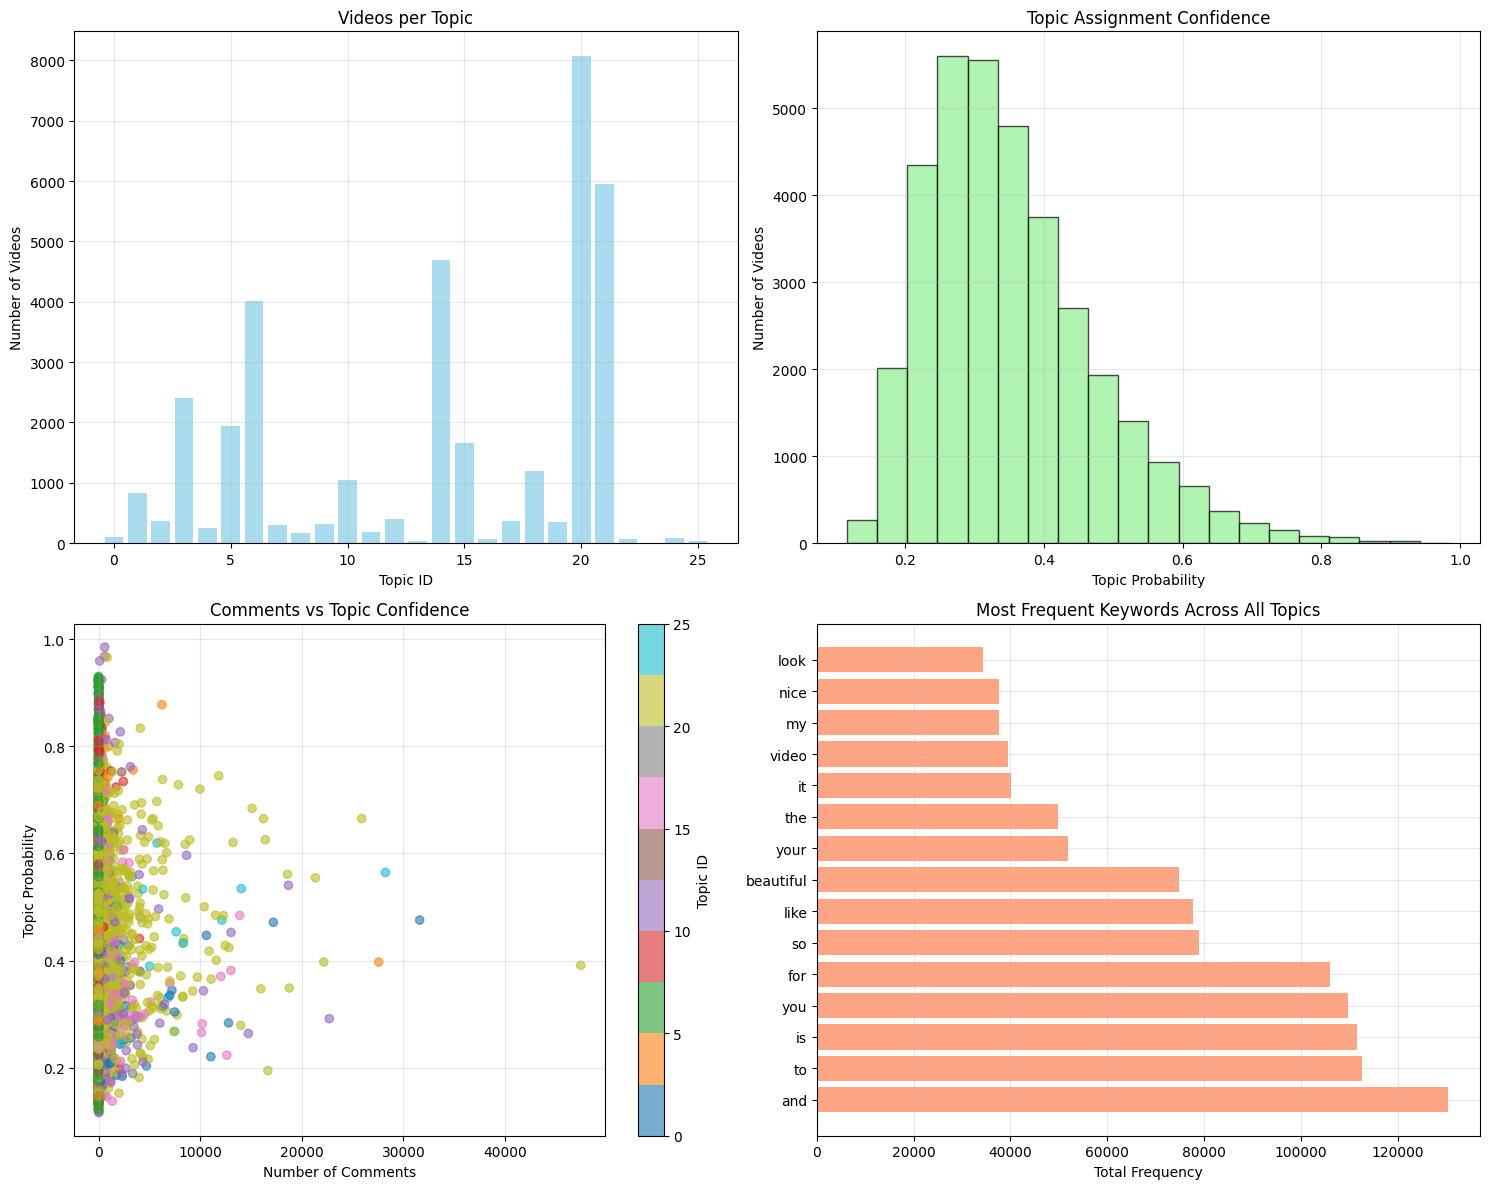

✅ Saved LDA model: model\lda_topic_model.pkl
✅ Saved Gensim LDA model: model\lda_model_gensim
✅ Saved LDA dictionary: model\lda_dictionary.dict

🎉 Topic modeling completed! Files created:
   📁 video_topics_assignment.csv - Video topic labels
   📁 topic_keywords_frequencies.csv - Topic keywords with frequencies
   📁 lda_topic_model.pkl - Trained model for future use


In [12]:
# Export Results and Create Visualizations
import joblib

print("Exporting topic modeling results...")

# 1. Export Video Topics CSV
video_topics_df.to_csv('video_topics_assignment.csv', index=False, encoding='utf-8')
print(f"✅ Exported video topic assignments: video_topics_assignment.csv")

# 2. Export Topic Keywords CSV  
topic_keywords_df.to_csv('topic_keywords_frequencies.csv', index=False, encoding='utf-8')
print(f"✅ Exported topic keywords: topic_keywords_frequencies.csv")

# 3. Create Summary Statistics
summary_stats = {
    'total_videos': len(video_topics_df),
    'total_topics': optimal_k,
    'avg_topic_probability': video_topics_df['topic_probability'].mean(),
    'total_pooled_documents': len(pooled_documents),
    'avg_comments_per_video': video_topics_df['num_comments'].mean(),
    'coherence_score': optimal_coherence
}

print(f"\n=== TOPIC MODELING SUMMARY ===")
print(f"Total Videos Analyzed: {summary_stats['total_videos']:,}")
print(f"Number of Topics Discovered: {summary_stats['total_topics']}")
print(f"Average Topic Confidence: {summary_stats['avg_topic_probability']:.3f}")
print(f"Pooled Documents Created: {summary_stats['total_pooled_documents']:,}")
print(f"Average Comments per Video: {summary_stats['avg_comments_per_video']:.1f}")
print(f"Model Coherence Score: {summary_stats['coherence_score']:.4f}")

# 4. Create Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Topic Distribution
topic_counts = video_topics_df['dominant_topic'].value_counts().sort_index()
axes[0, 0].bar(range(len(topic_counts)), topic_counts.values, color='skyblue', alpha=0.7)
axes[0, 0].set_xlabel('Topic ID')
axes[0, 0].set_ylabel('Number of Videos')
axes[0, 0].set_title('Videos per Topic')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Topic Confidence Distribution
axes[0, 1].hist(video_topics_df['topic_probability'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_xlabel('Topic Probability')
axes[0, 1].set_ylabel('Number of Videos')
axes[0, 1].set_title('Topic Assignment Confidence')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Comments vs Topic Confidence
scatter = axes[1, 0].scatter(video_topics_df['num_comments'], video_topics_df['topic_probability'], 
                            c=video_topics_df['dominant_topic'], cmap='tab10', alpha=0.6)
axes[1, 0].set_xlabel('Number of Comments')
axes[1, 0].set_ylabel('Topic Probability')
axes[1, 0].set_title('Comments vs Topic Confidence')
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 0], label='Topic ID')

# Plot 4: Top Keywords Frequency
top_keywords_overall = topic_keywords_df.groupby('keyword')['frequency'].sum().sort_values(ascending=False).head(15)
axes[1, 1].barh(range(len(top_keywords_overall)), top_keywords_overall.values, color='coral', alpha=0.7)
axes[1, 1].set_yticks(range(len(top_keywords_overall)))
axes[1, 1].set_yticklabels(top_keywords_overall.index)
axes[1, 1].set_xlabel('Total Frequency')
axes[1, 1].set_title('Most Frequent Keywords Across All Topics')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Save the trained model to model folder
import os

# Create model directory if it doesn't exist
model_dir = 'model'
os.makedirs(model_dir, exist_ok=True)

# Save LDA model artifacts
model_artifacts = {
    'lda_model': best_lda_model,
    'dictionary': dictionary,
    'optimal_k': optimal_k,
    'coherence_score': optimal_coherence,
    'topic_keywords': topic_keywords_df,
    'video_topics': video_topics_df,
    'summary_stats': summary_stats,
    'pooled_df': pooled_df
}

lda_model_path = os.path.join(model_dir, 'lda_topic_model.pkl')
joblib.dump(model_artifacts, lda_model_path)
print(f"✅ Saved LDA model: {lda_model_path}")

# Also save individual model components for easier loading
best_lda_model.save(os.path.join(model_dir, 'lda_model_gensim'))
dictionary.save(os.path.join(model_dir, 'lda_dictionary.dict'))
print(f"✅ Saved Gensim LDA model: {os.path.join(model_dir, 'lda_model_gensim')}")
print(f"✅ Saved LDA dictionary: {os.path.join(model_dir, 'lda_dictionary.dict')}")

print(f"\n🎉 Topic modeling completed! Files created:")
print(f"   📁 video_topics_assignment.csv - Video topic labels")
print(f"   📁 topic_keywords_frequencies.csv - Topic keywords with frequencies") 
print(f"   📁 lda_topic_model.pkl - Trained model for future use")